# Problem Set #1: Unsupervised Models of Early Visual System
**DUE 23 February 2021 - NEU 502A**

**Submission Directions:** Prior to submitting, clear you kernel and run through all your cells in order so figures and variables are accurately recorded. Only include cells with necessary code or answers, do not include cells used for troubleshooting. Email this notebook with your last name in the filename to Eleni (elenip@princeton.edu) by 5pm.

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.sparse as sparse
from scipy.spatial.distance import cosine

%matplotlib inline
sns.set_context('talk')

# 1. Principal Component Analysis of Natural Scenes
In lecture, various attempts to formulate a theory about V1’s functionality were discussed. It is clear that it is not just edge detection, or Fourier Decomposition, although it does have a mixture of these functionalities. Simple cells are tuned to sine waveforms, yet broadly tuned to different spatial frequencies. 

The generative model view of neural processing proposes that the early visual system is trying to identify the latent variables that generate a sensory stimulus. The visual stimulus emanates from the latent variables (i.e. natural scenes), is encoded by the sensory machinery, is and processed by cortical areas (i.e. Visual Cortex).

The sparse coding model suggests representing multidimensional space as linear combinations of basis vectors, requiring the weights for the linear combinations to be sparse. Olshausen and Field (1996) showed that these basis vectors turn out to resemble V1 receptive fields of mammalian visual cortex, when the model is applied to natural scenes. The method requires over-completion, with a larger number of basis vectors than sensory space vectors. On the other hand, PCA aims to represent the data with the fewest number of basis vectors possible.

In this problem we will find the principal components that account for the most variance of the information contained in natural images. These can be used to find a lower dimensionality descriptive space from which the natural scenes under study can be reconstructed. 

**a)	The visual system is composed of units that have increasing receptive field sizes as the information moves up the hierarchy. To approximate those in V1:**

:: i.	Load the 10 images found in “IMAGES_RAW.mat” file using the scipy.io function loadmat. 

In [2]:
from scipy.io import loadmat

#load data
mat = loadmat('IMAGES_RAW.mat')
images = mat['IMAGESr']

In [3]:
## utils

colors = plt.cm.YlOrRd(np.linspace(0, 1, 10))
cmap = 'Greys'

:: ii.	Extract 1000 12x12 pixel patches from each of the raw images. You should have 10,000 patches total with 1000 patches/image. Store the patches in a 144xN matrix P, where N = 10,000 and each column is a vectorized patch. 
Hint: you can use the function extract_packages_2d() in scikit learn image feature extraction package to do this. See section 4.2.4.1 of https://scikit-learn.org/stable/modules/feature_extraction.html#image-feature-extraction.

In [4]:
from sklearn.feature_extraction.image import extract_patches_2d

In [6]:
# extract patches
patches_2d = np.concatenate([extract_patches_2d(image=images[:,:,i], 
                                                patch_size=(12,12), 
                                                max_patches=1000, 
                                                random_state=0) 
                              for i in range(images.shape[-1])], axis=0)
# reshape
patches = patches_2d.reshape(patches_2d.shape[0], 144).T

:: iii.	Implement PCA on the matrix of sampled patches. First, compute the sample covariance (e.g. using np.cov). If you compute the sample covariance manually, remember to zero-mean the data. Next, compute an eigendecomposition of the sample covariance. The eigenvectors are the principal components (PCs) and the eigenvalues are the associated explained variance.

In [8]:
# covariance
cov = np.cov(patches)
eigen_values, eigen_vectors = np.linalg.eig(cov)

:: iv.	Plot the eigenspectrum of the covariance matrix. 

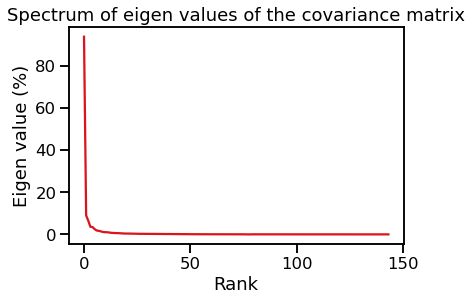

In [9]:
plt.title('Spectrum of eigen values of the covariance matrix')
plt.plot(eigen_values, c=colors[7])
plt.ylabel('Eigen value (%)')
plt.xlabel('Rank')
plt.show()

:: v.	Plot a sensible subset of the PCs with the same dimensionality as a sampled patch (12x12). How does this relate to V1 receptive fields?

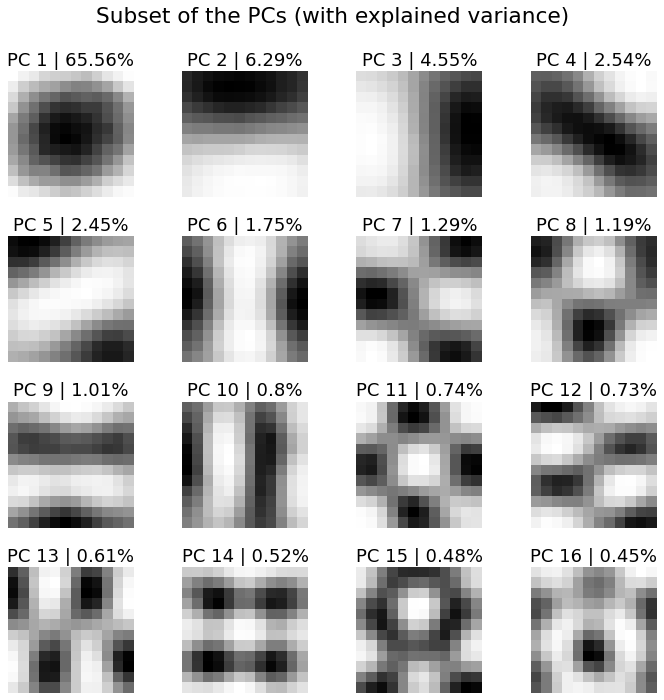

In [10]:
## calc explained variance
norm_eig_val = eigen_values / eigen_values.sum()

fig, axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle('Subset of the PCs (with explained variance)')
axes = axes.flatten()

for i,ax in enumerate(axes):
    
    ax.imshow(eigen_vectors[:,i].reshape(12,12), cmap=cmap)
    ax.set_title('PC {} | {}%'.format(i+1,
                                    np.round(norm_eig_val[i]*100, 2)))
    ax.set_axis_off()
    
plt.tight_layout()
plt.show()

>**Answer:** The principal components (i.e., the eigenvectors) seem like linear filters, specifically those aim at edges or textures detection. A famous example of such filters is the Gabor filters, which are similar to those of the human higher visual system (simple V1 cells).

**b)	Each PC is characterized by an associated eigenvalue, which is a fraction of the total variance in the sample patches explained by the PC. Use these to implement dimensionality reduction and retain [0.9 0.95 0.99 0.9999] of the variance respectively.**

:: i.	Find the number (k) of PCs required to account for 90% of the total variance and extract the corresponding PCs. Then do so for the other fractions of the total variance.

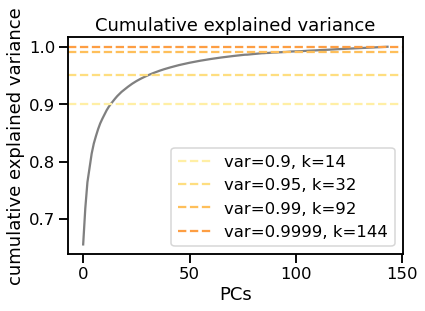

In [60]:

thresholds = [0.9, 0.95, 0.99, 0.9999]

norm_eig_val = eigen_values / eigen_values.sum()
cum_var_exp = np.cumsum(norm_eig_val)

# get k PCs needed
k = []
for threshold in thresholds:
    k.append(np.argmax(cum_var_exp > threshold)+1)

    
plt.title('Cumulative explained variance')
plt.plot(cum_var_exp, c='grey')

for i, (t, k_i) in enumerate(zip(thresholds, k)):
    plt.axhline(y = t, c = colors[i+1], linestyle = '--', label='var={}, k={}'.format(t,k_i))

        
plt.legend()
plt.ylabel('cumulative explained variance')
plt.xlabel('PCs')
plt.show()


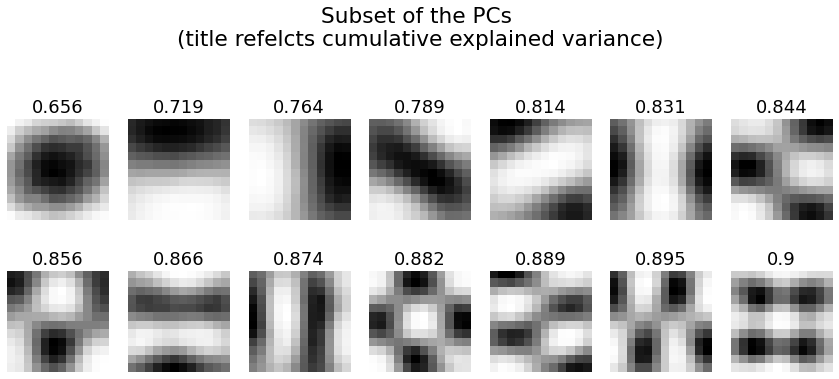

In [12]:
# corresponding PCs for var = 90%
## calc explained variance

fig, axes = plt.subplots(2, 7, figsize=(12,6))
fig.suptitle('Subset of the PCs \n(title refelcts cumulative explained variance)')
axes = axes.flatten()

for i,ax in enumerate(axes):
    
    ax.imshow(eigen_vectors[:,i].reshape(12,12), cmap=cmap)
    ax.set_title('{}'.format(np.round(cum_var_exp[i], 3)))
    ax.set_axis_off()
    
plt.tight_layout()
plt.show()

:: ii.	For k = 1 and for each k above, project the patches onto the selected PCs and then project them back to the original data space to obtain the reconstructed patches. For example, if the matrix V has the top k PCs as columns, we can accomplish this via the multiplication V V’ P, where V’ is the transpose of V. 

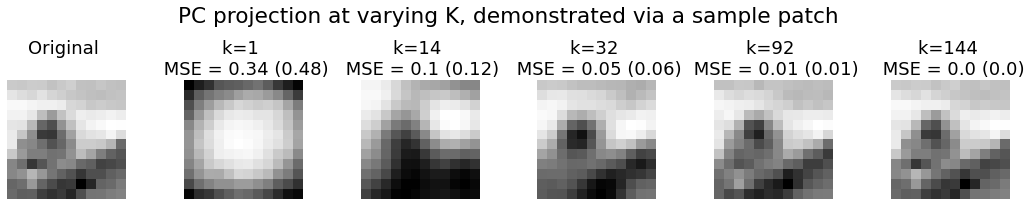

In [12]:

mse_for_k = []

fig, axes = plt.subplots(1, 6, figsize=(15,3))
sample_patch_id = 10

fig.suptitle('PC projection at varying K, demonstrated via a sample patch')
axes[0].set_title('Original \n')
axes[0].imshow(patches[:,sample_patch_id].reshape(12,12), cmap=cmap)
axes[0].set_axis_off()

for k_i, ax in zip([1]+k, axes[1:]):
    
    # get projection
    projection = eigen_vectors[:,:k_i] @\
                eigen_vectors[:,:k_i].T 
    
    # get reconstruction
    reconstructed_patches = projection@\
                        patches[:,sample_patch_id]
    
    reconstructed_patches_2d = reconstructed_patches.reshape(12,12)
    
    # calc mse
    mse = [np.power(patches[:,i] - projection@patches[:,i] , 2).mean()\
               for i in range(patches.shape[1])]
    mse_for_k.append(mse)
    ax.set_title('k={} \n MSE = {} ({})'.format(k_i,
                                         np.round(np.mean(mse),2),
                                           np.round(np.std(mse),2)))
    
    ax.imshow(reconstructed_patches_2d, cmap=cmap)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

:: iii.	Plot a selection of 5 reconstructed patches for each reduced space, next to the originals, for a total of 30 patches. Make sure that the patches are size 12x12. 

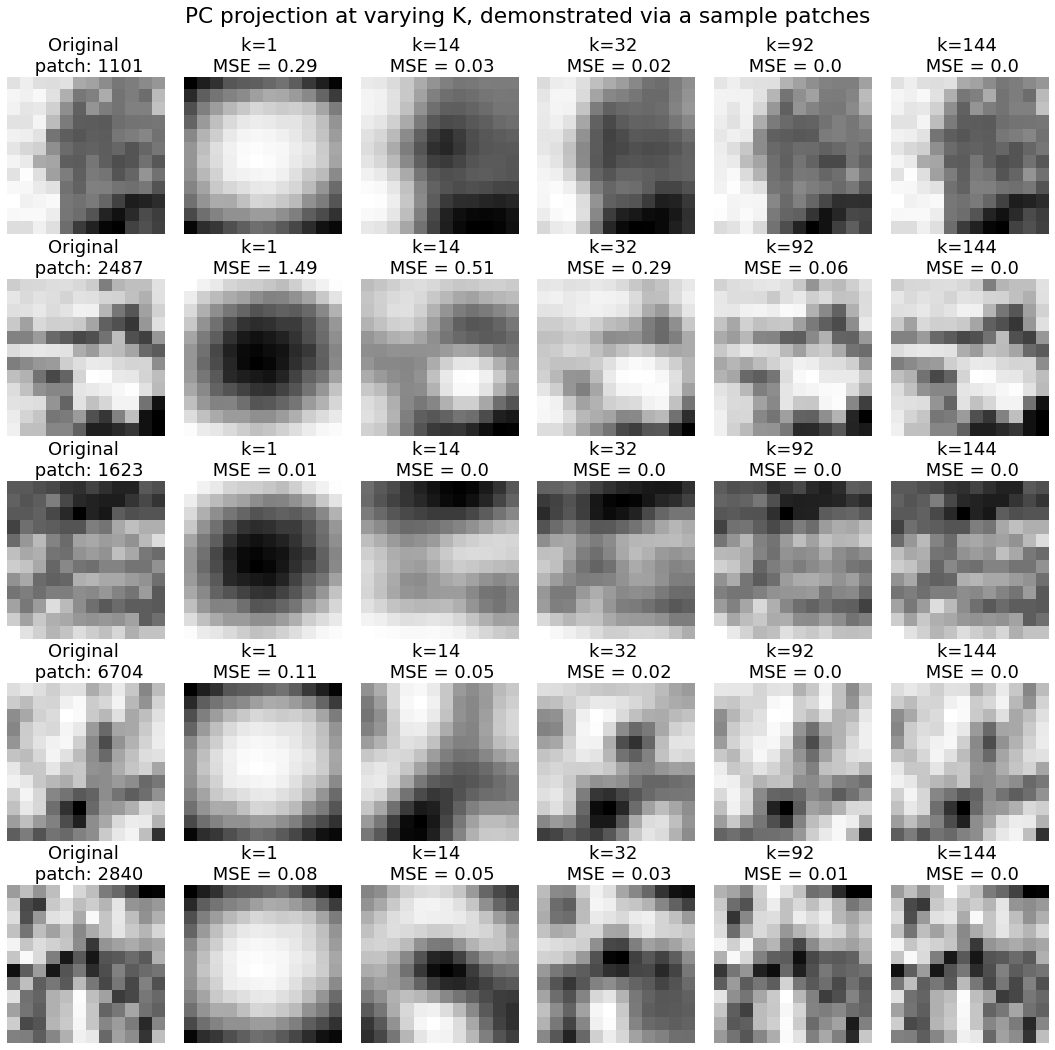

In [13]:
#patches_2d.shape
#eigen_vectors[:,0].shape

fig, axes = plt.subplots(5, 6, figsize=(15,15))
sample_patch_ids = np.random.choice(patches.shape[1], 5)

fig.suptitle('PC projection at varying K, demonstrated via a sample patches')


for j, patch in enumerate(sample_patch_ids):
    
    axes[j][0].set_title('Original \n patch: {}'.format(patch))
    axes[j][0].imshow(patches[:,patch].reshape(12,12), cmap=cmap)
    axes[j][0].set_axis_off()

    for i, k_i in enumerate([1]+k):

        # get projection
        projection = eigen_vectors[:,:k_i] @\
                    eigen_vectors[:,:k_i].T 

        # get reconstruction
        reconstructed_patches = projection@\
                            patches[:,patch]

        reconstructed_patches_2d = reconstructed_patches.reshape(12,12)

        # calc mse
        mse = np.power(patches[:,patch] - projection@patches[:,patch],2).mean()

        axes[j][i+1].set_title('k={} \n MSE = {}'.format(k_i, 
                                                         np.round(mse,2)))

        axes[j][i+1].imshow(reconstructed_patches_2d, cmap=cmap)
        axes[j][i+1].set_axis_off()

plt.tight_layout()
plt.show()

:: iv.	Provide a measure of how much information is lost in each case (MSE).

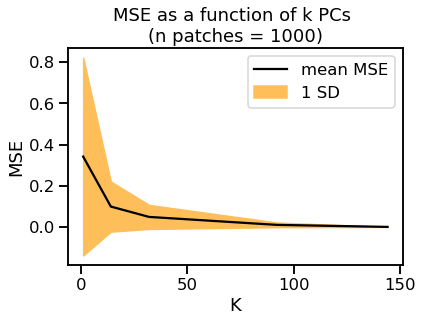

In [14]:
mse_mean = np.array([np.mean(mse) for mse in mse_for_k])
mse_std = np.array([np.std(mse) for mse in mse_for_k])


plt.title('MSE as a function of k PCs \n(n patches = 1000)')

plt.plot([1]+k, mse_mean, 'k-', label='mean MSE')
plt.fill_between([1]+k, mse_mean-mse_std, mse_mean+mse_std, 
                 color=colors[3], label='1 SD')

plt.xlabel('K')
plt.ylabel('MSE')

plt.legend()
plt.show()

# 2. Hebbian Learning

Here the original quote from Hebb:

“Let us assume that the persistence or repetition of a reverberatory activity (or "trace") tends to induce lasting cellular changes that add to its stability. […] When an axon of cell A is near enough to excite a cell B and repeatedly or persistently takes part in firing it, some growth process or metabolic change takes place in one or both cells such that A's efficiency, as one of the cells firing B, is increased.”

It seems Hebb was referring in his own words to Spike-Timing-Dependent-Plasticity, where the lags between pre- and post-synaptic neurons are responsible for LTP or LTD, depending on which fires first. (The story is not as simple though...)  The simplest learning rule following this description of plasticity takes the following form:

$$ (Eq.1): \tau_w \frac{dw}{dt} = vu $$ 
<img src="weights.png" width="250">            
    

where $u$ is the input vector containing the activities (i.e. firing rate) of the presynaptic elements. This basic rule includes a single postsynaptic element denoted by $v$. The weight vector is denoted by $w$, representing the synapses between pre-and postsynaptic neurons. The parameter $τ_w$ controls the rate at which weights between presynaptic and postsynaptic elements change (i.e. time required for a fractional change in the weights). The output of the postsynaptic element $v$ is given by:

$$ (Eq.2): v = \vec{w} \cdot \vec{u} = \sum w_i u_i $$       

We need to modify the rule described in Eq. 1, which is unstable and lacks competition between synapses. The instability comes from unbounded growth of the weight vector. To deal with this limitation, we will use a modified version of Hebb’s rule called Oja’s Rule:

$$ (Eq.3): \tau_w \frac{dw}{dt} =  v\vec{u} - \alpha v^2\vec{w} $$     

In Eq. 3, α is a positive constant controlling the pull from the multiplicative normalization term $v^2w$. This term limits the growth of the weight vector, eliminating one of the limitations of the basic rule. 

**a)	Now, train a feedforward Hebbian neural network with one output element and N = 144 input units (to match the size of the image patches from 1.) using Oja’s rule.** 

:: i. First, setup the network. Sample the initial value of each weight $w_i$ from a normal distribution with mean zero and variance 1e-4. Set the parameters $α$ = 10 and $τ_w$= 2000. 

In [15]:
# utils
np.random.seed(0)

In [16]:
n_features, n_stimuli = patches.shape #144,10000

# init params
w = np.random.normal(0, 1e-4, n_features)
tau_w = 2000
alpha = 10

n_iter = 1000
n_inputs = 100

# equations

# postsynaptic output
get_v = lambda u, w : u@w
# Oja rule
get_dw = lambda v, u, alpha, tau_w: (u * v - alpha * v**2 * w) / tau_w


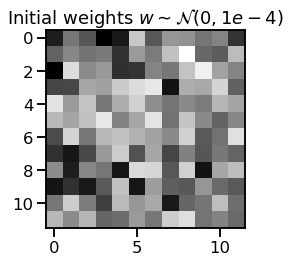

In [17]:
plt.title(R'Initial weights $w\sim\mathcal{N}(0,1e-4)$')
plt.imshow(w.reshape(12,12), cmap=cmap)
plt.tight_layout()
plt.show()

:: ii. Train the network in batches of 500 inputs, where the input $u$ is a single patch from Part I in vectorized form. Randomly select 500 image patches and compute the mean $dw⁄dt$ using Oja’s rule across all of the image patches in the batch (don’t forget to divide by $τ_w$). Use the mean $dw⁄dt$ to update $w$. 

In [18]:
n_batches = 500
n_inputs = 500

sample_inputs = np.random.choice(np.arange(n_stimuli), n_inputs, replace=False)
w = np.random.normal(0, 1e-4, n_features)
for i in np.arange(n_batches):
    dw = np.zeros_like(w, dtype=float)
    
    for stim_id in sample_inputs:
        # get output
        input_vector = patches[:,stim_id]
        output_vector = get_v(input_vector, w)

        # compute new weights
        dw = get_dw(output_vector, input_vector,  alpha, tau_w) 
        w += dw/n_inputs #avg
    
        


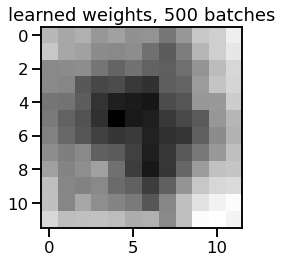

In [19]:
plt.title(R'learned weights, {} batches'.format(n_batches))
plt.imshow(w.reshape(12,12), cmap=cmap)
plt.tight_layout()
plt.show()

:: iii.	Repeat ii) for 1000 iterations. 

In [20]:
n_batches = 1000
n_inputs = 500

sample_inputs = np.random.choice(np.arange(n_stimuli), n_inputs, replace=False)
w = np.random.normal(0, 1e-4, n_features)
w_history = np.zeros((n_batches, n_features))

for batch_i in np.arange(n_batches):
    dw = np.zeros_like(w, dtype=float)
    
    for stim_id in sample_inputs:
        # get output
        input_vector = patches[:,stim_id]
        output_vector = get_v(input_vector, w)

        # compute new weights
        dw = get_dw(output_vector, input_vector,  alpha, tau_w) 
        w += dw/n_inputs #avg
    
    w_history[batch_i]=w  


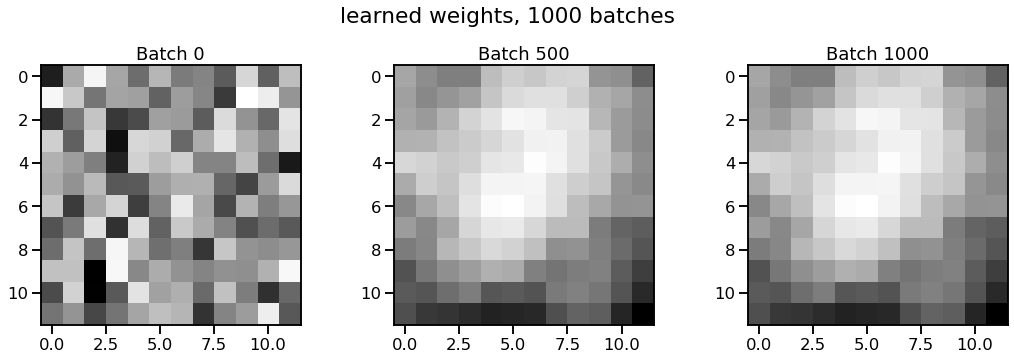

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle(R'learned weights, {} batches'.format(n_batches))
axes[0].set_title('Batch 0')
axes[0].imshow(w_history[0].reshape(12,12), cmap=cmap)
axes[1].set_title('Batch 500')
axes[1].imshow(w_history[500].reshape(12,12), cmap=cmap)
axes[2].set_title('Batch 1000')
axes[2].imshow(w.reshape(12,12), cmap=cmap)

plt.tight_layout()
plt.show()

:: iv. Track the magnitude of the weight vector at each iteration and plot the progression. Show that the magnitude stabilizes when the stimuli are learned by showing $|w|^2  ≈  1⁄α$  as $t→ ∞$ (here time is represented by samples seen). What does this imply about the modified Hebbian rule? What does it predict about the dynamics of the weights throughout learning?

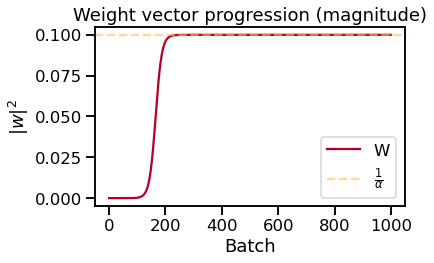

In [23]:
plt.title('Weight vector progression (magnitude)')

plt.plot(np.linalg.norm(w_history, axis=1)**2, 
         c=colors[8], label='W')
plt.axhline(1/alpha, c=colors[3], alpha=.6, 
            linestyle='--', label=r'$\frac{1}{\alpha}$')

plt.xlabel('Batch')
plt.ylabel(r'$|w|^2$')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

>**Answer:** The Oja rule introduces a feddback term (parametarized by $\alpha$), which presents a normalization that is dealing with the instability limitation - practically limits the growth of the weight vector. Practically, it bounds the weights - which otherwise would have grown infinitely - making the Hebbian network stable at an asymptotic value of $\frac{1}{\alpha}$



:: v.	Use any method you can think of to show that the weight vector of this single output Hebbian network captures the direction of the first principal component of the patches obtained in Part I. Show the evidence. 

>**Method:**  The cosine similarity always belongs to the interval [-1,1] where two proportional vectors have a cosine similarity of 1, two orthogonal vectors have a similarity of 0, and two opposite vectors have a similarity of -1. 

> $cos(\theta) = \frac{U \cdot V}{|U||V|}$

>**Answer:** $cos(\theta) = \frac{PC1 \cdot w}{|PC1||w|} = 1$.
> Not surpsignly (since it is a property of the eigen vectors), but a cool validation, the 2nd PC is orthogonal to the direction of the weights.

In [69]:
print("PC1 & hebbian weights", np.round(np.abs(1-cosine(eigen_vectors[:,0], w)), 3))
print("PC2 & hebbian weights", np.round(np.abs(1-cosine(eigen_vectors[:,1], w)), 3))


PC1 & weight 0.999
PC2 & weight 0.027


:: vi. What would happen if the network had multiple postsynaptic elements  $v$, for which each output element had a set fully connected weights from the input units? Consider that the update rules are local, so each output neuron only depends on the inputs and the associated weights. 

>**Answer:** The type of network described is a generalized Hebbian algorithm (Sanger's rule) - a multiple output hebbian network. Practically we now will have N outputs and could extract as many features as desired.


> Sanger T. D. (1989) Optimal unsupervised learning in a single-layered linear feedforward network. Neural Networks, 2:459-473

:: vii.	What modification could overcome the limitations of this implementation of Hebbian learning (you do not need to implement anything here, just answer in words)?

>**Answer:** *Nonlinear Hebbian learning* is impossible with the current implementation. Hyvärinen et al. (2001, 1998) show that with slight network modification, such learning is possible. An Independent Component Analysis (ICA), rather than a PCA, could help overcome this limitation. Practically, one needs to modify the output factor and the feedback term to be nonlinear.



> Hyvärinen A., Karhunen J., and Oja E. (2001) Independent component analysis. Wiley
> Hyvärinen A. and Oja E. (1998) Independent component analysis by general nonlinear Hebbian-like learning rules. Signal Processing, 64:301-313

# 3. Feature-Based Model of Ocular Dominance and Orientation Selectivity

Inspection of V1 anatomy shows that alternating columns of cells respond preferentially to input from the left and right eyes, respectively. These are referred to as ocular dominance columns. Next, Hubel & Wiesel shows that subsets of cells in V1 are selective to different orientations of light bars moving across their receptive fields. They proposed the Ice Cube Model, where columns of iso-oriented cells span each cortical column of iso-ocular cells. Optical imaging experiments have shown that iso-oriented cells tend to be closer together, giving rise to differentiated “columns” of cortex. An image of a patch of macaque monkey primary visual cortex containing both feature selective structures is shown in Figure 3A. 

The areas separated by the black lines are the ocular dominance columns, and the grey lines denote iso-orientation contours. Pinwheels are the singularities where all orientations meet. Linear zones are extended regions where iso-orientation contours are parallel. These structures develop as the system receives inputs across the spectrum of these sensory dimensions. 
    <img src="OD.png" width="600">
    
Similar mappings can be obtained using competitive feature-based models that are adapted to consider ocularity and orientation selectivity. One such model is the Elastic Net Model, from which a modeled map is shown in Figure 3B (Figure from Erwin et al. 1995, “Models of Orientation and Ocular Dominance Columns in the Visual Cortex: A Critical Comparison”).

Modeling cortical map formation with Hebbian models is highly complex. Models of the development of these cortical maps require consideration of retinotopic location, ocular dominance, and orientation preference to be considered simultaneously within the dynamics of the network. Competitive feature-based models provide a simpler framework to describe map development. These models characterize neurons and their inputs by feature selectivity, unlike Hebbian models, which use synaptic weights. By the end of development, the receptive field of a cortical cell can be characterized by three values: ocularity, mean topographic location of inputs, and orientation selectivity.
For more details, see (Erwin et al. 1995) as referenced above, in particular Figures 10 and 11 and the appendix.

**a)	Implementing the Elastic Net Model**

Write code to simulate cortical column formation by implementing the Elastic Net Model. In the elastic net model, each cortical unit i is represented by a five-dimensional vector $v_i = [x_i,y_i,o_i,e_i*cos(2θ_i ),e_i*sin(2θ_i )]$. Each element of the vector represents a feature, and the five features are the x and y positions of the retinal location of the unit’s receptive field, the unit’s ocularity preference o, the orientation preference $θ$, and orientation preference strength $e$. Negative (positive) values of ocularity correspond to left (right) eye preference.

:: i. For N = 50, generate an N by N 2D grid. Each point on this grid corresponds to the location of a cortical unit such that there are N^2  cortical units in total. We recommend starting with N = 10 or N = 20 for debugging purposes.

In [71]:
# init params
N = 50 #to be 50

n_params = 5
V = np.zeros((N**2, n_params))

topographic_loc = np.array(np.meshgrid(np.arange(N), 
                                       np.arange(N))).T.reshape(N*N,2)

:: ii. Compute the adjacency matrix $A$ of the 2D grid. The adjacency matrix is a square matrix whose dimension is equal to the number of units, such that it is size $N^2$ by $N^2$ that specifies whether two units are neighbors or not. Set $A_ij = 1$ if units $i$ and $j$ are neighbors, otherwise set $A_ij = 0$. Units are neighbors if they are directly to the North, South, East, or West of each other on the 2D grid. Use circular boundary conditions such that the units on the left side of the grid are neighbors with units on the right side of the grid.
Hint: For example, the locations of the neighbors of the unit at location (0,0) are (0,1), (1,0), (49,0), and (0,49). 
Hint 2: If you define A to be a sparse matrix, your code will run faster. 

In [72]:
A = np.zeros((N**2,N**2))

topographic_loc

for i, cell_i in enumerate(topographic_loc):
    for j, cell_j in enumerate(topographic_loc):
        
        diff = abs(cell_i - cell_j)
        
        #normal case
        if (diff[0] == 0 and diff[1] == 1) or\
                (diff[1] ==0 and diff[0] ==1): 
            A[i,j]=1

            #edge cases
        if (diff[0] == 0 and diff[1] == (N-1)) or\
                (diff[1] ==0 and diff[0] == (N-1)):
            A[i,j]=1

A_sparse = sparse.csr_matrix(A.astype(bool).astype(int))    

:: iii. Generate a matrix V that contains the feature vectors of all $N^2$ cortical units, such that $V$ has $N^2$ rows and 5 columns. Set the first and second columns to be the $x$ and $y$ locations of the units on the 2D grid, respectively. Let $o_max=46.08$ and $e_max=61.44$. Initialize all $o_i=0$ (set the third column of $V$ equal to 0). Finally, for the 4th and 5th columns, set $e_i=0.01*e_max$, and $θ_i$ equally spaced between 0 and $pi$. 

In [73]:
o_m = 46.08
e_m = 61.44
e_i = 0.01
theta = 2*np.linspace(0, np.pi, N**2)

# assign topographic locations
V[:, 0:2] = topographic_loc

# set 4th and 5th cols - 𝑒𝑖∗𝑒m*𝑐𝑜𝑠(2θ𝑖),𝑒𝑖∗𝑒m*𝑠𝑖𝑛(2θ𝑖)
V[:, 3] = e_i * e_m * np.cos(2*theta)
V[:, 4] = e_i * e_m * np.sin(2*theta)


:: iv. Stimuli $u_i$ in this model are represented by a vector with the same representation as the cortical units such that $u_i = [x_i,y_i,o_i,e_i*cos(2θ_i ),e_i*sin(2θ_i )]$.  Generate 2,000,000 stimuli and store them as the rows of a matrix $U$. The stimulus values should be drawn randomly with uniform probability from the following ranges:

$$x, y \in [0, N-1]; o \in [-o_{max}, o_{min}]; e \in [0, e_{max}]; \theta \in [0, \pi]].$$ Hint: remember to multiply 𝜃 by 2 before applying cos and sin, for both stimuli and units.

In [74]:
np.random.seed(0)

# generate simulate data
n_stimuli = int(2e6)

U = np.zeros((n_stimuli, n_params))
theta_for_stim = 2*np.random.uniform(0, np.pi, n_stimuli)

U[:, 0] = np.random.uniform(0, N, n_stimuli)
U[:, 1] = np.random.uniform(0, N, n_stimuli)
U[:, 2] = np.random.uniform(-1*o_m, o_m, n_stimuli)
U[:, 3] = e_i * e_m * np.cos(theta_for_stim)
U[:, 4] = e_i * e_m * np.sin(theta_for_stim)


:: v. For each stimulus, update the feature selectivity matrix $V$ using the following equations. First, compute a vector of $N^2$ weights:

 $$w=[(w_1, …, w_{N^2})].T$$
 
 $$ w_j = \frac{f \left(u_iv_j \sigma \right)}{\sum_k f \left( u_iv_k\sigma \right)} $$
 
 $$ f \left( u,v,\sigma \right) = \text{exp} \left( \frac{-| u-v_i |^2}{2 \sigma^2} \right)  $$ where $|u-v|$ is the Euclidean distance between $u$ and $v$, $σ = 2.771$, and each weight is normalized by the sum of the rest of the weights. Next, update the cortical unit values with:
 
 $$ V_{i+1} = V_i + \alpha w \cdot (u_i - V_i) + \beta \sum_{neighbors in loc=(N,E,W,S)} V^{loc}_i - V_i  $$
 $$ V_{i+1} = V_i + \alpha w \cdot (u_i - V_i) + \beta (A V_i - 4 V_i)$$
 
 where $α=0.4$ and $β=0.0001$, and $V_i$ are the values of the cortical units at time $i$. The neighbors $V^{loc}_i$ are the neighbors of each cortical unit $v_i$, which fill the rows of $V^loc$. However, we can more efficiently compute the summation using the adjacency matrix $A$ as shown in the second line of the above equation, which alleviates the need to compute $V^loc$.

In the above equation, $(u_i-V_i )$ means that the current stimulus vector $u_i$ is subtracted from each row of $V_i$. Next, the notation $w .*(u_i-V_i)$ means multiply each column of $(u_i-V_i )$ element-wise by the vector $w$. Hint: both operations in $w .*(u_i-V_i )$ can be easily accomplished via array broadcasting!
 
In summary, in this model the cortical unit activities are changed by two terms. In the first, the units are updated by their difference from the input $u_i$, with the weight vector $w$ serving as a normalizing force. The second term promotes units having similar selectivity to their neighbors. In the model, $α$ and $β$ control the tradeoff between these two terms, and $σ$ controls the effective range (distance) between an input and the cortical neurons. If implemented as described, the simulation can take around 15-20 minutes. Implement a progress bar and be sure to save your run.

In [168]:
from tqdm import tqdm #allow progress bar display

alpha = 0.4
beta = 1e-4
sigma = 2.771

f = lambda v, u, sigma: np.exp(-1*(np.linalg.norm(u-v, axis=1) ** 2) / (2*sigma ** 2) )

for i in tqdm(range(n_stimuli)):
    # get weight vector
    w_i = f(V, U[i], sigma)
    w_i /= w_i.sum()
    
    # update value
    V += alpha  * (w_i*(U[i] - V).T).T + beta * (A @ V - 4*V)
np.save('V_2e6_n=50_2.npy', V)            

100%|██████████| 2000000/2000000 [3:10:37<00:00, 174.86it/s]  


In [75]:
# load instead of running...
V = np.load('V_2e6_n=50_2.npy')

In [106]:
ocularity = V[:,2].reshape(N,N)
ocularity_thres = np.where(ocularity>0, 1, -1)
orientation = np.arctan2(V[:,-2], V[:,-1]).reshape(N,N)
orientation_levels = np.linspace(orientation.min(), 
                                 orientation.max(), 10)



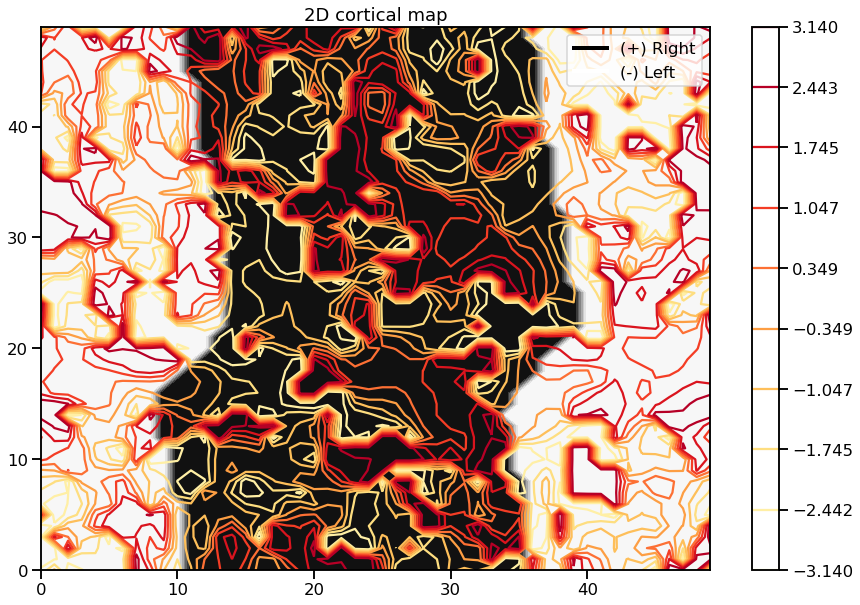

In [107]:
fig, axes = plt.subplots(figsize=(15,10))
plt.title('2D cortical map')
plt.contourf(ocularity_thres, cmap=cmap)
plt.contour(orientation, cmap='YlOrRd', levels=orientation_levels)
plt.colorbar()

custom_lines = [Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='white', lw=4)]

plt.legend(custom_lines, ['(+) Right', '(-) Left'])
plt.show()

:: vi.	After the simulation is over, plot the resulting 2D cortical map. First, threshold the ocularity above and below zero, such that values above zero are 1 and values below zero are -1. Plot the filled contours of ocularity using the contourf() function from matplotlib. Next, compute the orientation selectivity preference for each unit and plot contour lines of iso-orientation using the countour() function in matplotlib. Plot enough lines such that the contour lines represent changes of 15degrees. Note that these plots require mapping the values in the matrix V back to the original 2D locations of the units, as this plot should like a smaller piece of Figure 3B. (Emphasis on “similar”, as it will not be identical due to differences in some parameters and thresholding for contours). When converting to the 2D cortical map, make sure to use the locations of the cortical units as defined in part i). 

:: vii. 	Eye depravation: Run a new model with the same parameters and initial conditions, except with a new distribution of ocularity values for the stimuli. The task is to simulate deprivation of the right eye. To do this, generate stimuli with ocularity values in o ϵ $[-o_max,(γ*o)_max]$, where $γ=1/2$. This increases the frequency of negative values (left eye) of $o$, and limits the strength of positive values (right eye). Plot the results in a similar fashion to part a). Next, plot the distribution of ocularity values for simulation a) and simulation b) on a new plot. How do the results relate to what is known about eye deprivation?

Example simulation from a) with N = 20:

<img src="ED.png" width="400">   

The black and white areas are filled contours representing left and right eye ocularity. The thin lines represent varying contours of orientation selectivity. There is a clear ocular dominance column in the middle rows of the sheet and a pinwheel on the right hand side of the figure. 

In [101]:
V_depravation = np.zeros((N**2,n_params))

V_depravation[:,:2] = np.array(np.meshgrid(np.arange(N), 
                            np.arange(N))).T.reshape(N**2,2)

# assign topographic locations
V_depravation[:, 0:2] = topographic_loc
V_depravation[:, 3] = e_i * e_m * np.cos(theta)
V_depravation[:, 4] = e_i * e_m * np.sin(theta)



U_depravation = np.zeros((n_stimuli, n_params))

U_depravation[:, 0] = np.random.uniform(0, N, n_stimuli)
U_depravation[:, 1] = np.random.uniform(0, N, n_stimuli)
U_depravation[:, 2] = np.random.uniform(-1*o_m, .5*o_m, n_stimuli)
U_depravation[:, 3] = e_i * e_m * np.cos(theta_for_stim)
U_depravation[:, 4] = e_i * e_m * np.sin(theta_for_stim)


In [161]:
for i in tqdm(range(n_stimuli)):
    # get weight vector
    w_i = f(V_depravation, U_depravation[i], sigma)
    w_i /= w_i.sum()
    
    # update value
    V_depravation += alpha  * (w_i*(U_depravation[i] - V_depravation).T).T +\
                beta * (A @ V_depravation - 4*V_depravation)
    
np.save('V_depravation_2e6_n=50.npy', V_depravation)            

100%|██████████| 2000000/2000000 [6:40:57<00:00, 83.14it/s]       


In [102]:
V_depravation = np.load('V_depravation_2e6_n=50.npy')

In [108]:
ocularity_dep = V_depravation[:,2].reshape(N,N)
ocularity_dep_thres = np.where(ocularity_dep>0, 1, -1)
orientation_dep = np.arctan2(V_depravation[:,-2], V_depravation[:,-1]).reshape(N,N)



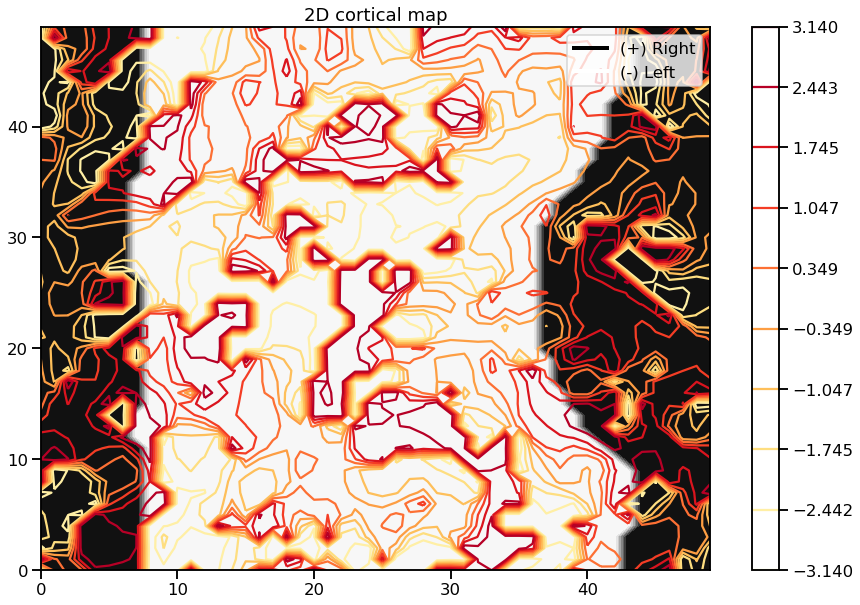

In [109]:
fig, axes = plt.subplots(figsize=(15,10))
plt.title('2D cortical map')
plt.contourf(ocularity_dep_thres, cmap=cmap)
plt.contour(orientation_dep, cmap='YlOrRd', levels=orientation_levels)
plt.colorbar()

custom_lines = [Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='white', lw=4)]

plt.legend(custom_lines, ['(+) Right', '(-) Left'])
plt.show()

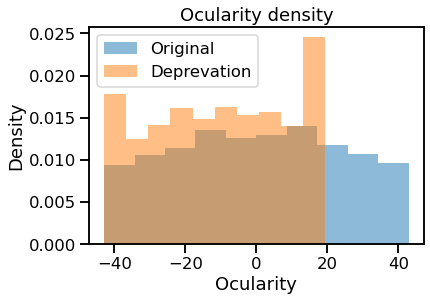

In [110]:
plt.title('Ocularity density')
plt.hist(V[:,2], density=True, alpha=.5, label='Original')
plt.hist(V_depravation[:,2], density=True, alpha=.5,  label='Deprevation')
plt.xlabel('Ocularity')
plt.ylabel('Density')

plt.legend()


> **Answer:** While the original case exhibits a somewhat symmetrical distribution over positive (right) and negative (left) values (ocularity). The deprived distribution is skewed negatively (left) - demonstrating the sparsity of columns representing the deprived eye. 